# Setup

In [1]:

import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo 
import joblib 
import pickle



# Creating classes

In [229]:
class AppendicitisModel:
    def __init__(self):
        self._raw_df = None  # Private attribute to store raw DataFrame
        self._features = None  # Private attribute for features
        self._targets = None  # Private attribute for targets
        self._variables = None  # Private attribute for variables
        self._continuous_features = None # Private attribute for continuous features
        self._categorical_features = None # Private attribute for categorical features 
        self._integer_features = None # Private attribute for integer features 
        self._binary_features = None # Private attribute for binary features
        self._target = None # Private attribute for binary features 
        self._continuous_df_features = None # Private attribute for normalized continuous features
        self._categorical_df_features = None # Private attribute for encoded categorical features
        self._selected_features = None   # Private attribute for engineered features
        self._X_preprocessed = None # Private attribute for preprocessed features 
        self._y_preprocessed = None # Private attribute for preprocessed target 
        self._preprocessed_data = None # Private attribute for preprocessed data
        self._X_train = None # Private attribute for training dataset
        self._X_test = None # # Private attribute for test dataset
        self._y_train = None # # Private attribute for training dataset
        self._y_test = None # Private attribute for test dataset
        self._rf_classifier = None # Private attribute random forest objectß
        self._y_pred = None # Private attribute for obtained predictions
        self._accuracy = None # Private attribute for obtained accuracy
        self._confusion_matrix = None # Private attribute for obtained confusion matrix

    @property
    def features(self):
        """Return the features of the dataset."""
        return self._features

    @property
    def targets(self):
        """Return the targets of the dataset."""
        return self._targets

    @property
    def raw_df(self):
        """Return the raw DataFrame containing features and targets."""
        return self._raw_df

    @property
    def variables(self):
        """Return the variables of the dataset."""
        return self._variables
    
    @property
    def continuous_features(self):
        """Return the continuous_features of the dataset."""
        return self._continuous_features
    
    @property
    def categorical_features(self):
        """Return the categorical_features of the dataset."""
        return self._categorical_features
    
    @property
    def integer_features(self):
        """Return the integer_features of the dataset."""
        return self._integer_features
    
    @property
    def binary_features(self):
        """Return the binary features of the dataset."""
        return self._binary_features
     
    @property
    def continuous_df_features(self):
        """Return the transformed continuous_features of the dataset."""
        return self._continuous_df_features 

    @property
    def categorical_df_features(self):
        """Return the transformed categorical_features of the dataset."""
        return self._categorical_df_features 
    
    @property
    def X_preprocessed(self):
        """Return the preprocessed x features of the dataset."""
        return self._X_preprocessed

    @property
    def y_preprocessed(self):
        """Return the preprocessed y features of the dataset."""
        return self._y_preprocessed

    @property
    def preprocessed_data(self):
        """Return the preprocessed preprocessed dataset."""
        return self._X_preprocessed_data
    
    @property
    def X_train(self):
        """Return the preprocessed x_train dataset."""
        return self._X_train

    @property
    def X_test(self):
        """Return the preprocessed x_test dataset."""
        return self._X_test

    @property
    def y_train(self):
        """Return the preprocessed y_train dataset."""
        return self._y_train

    @property
    def y_test(self):
        """Return the preprocessed y_test dataset."""
        return self._y_test
    
    @property
    def rf_classifier(self):
        """Return the classifier model."""
        return self._rf_classifier

    @property
    def y_pred(self):
        """Return the predictions from the model."""
        return self._y_pred
    
    @property
    def accuracy(self):
        """Return the accuracy of the model."""
        return self._accuracy

    @property
    def confusion_matrix(self):
        """Return the confusion matrix."""
        return self._confusion_matrix
    
    @property
    def selected_features(self):
        """Return the selected continuous features."""
        return self._selected_features


    def import_rawdata(self):
        """Fetch dataset and create dataframes for features, targets, raw_df, and variables."""
        # Fetch dataset 
        regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 

        # Create dataframes (features, targets, variables, raw_df)
        self._features = regensburg_pediatric_appendicitis.data.features 
        self._targets = regensburg_pediatric_appendicitis.data.targets 
        self._raw_df = pd.concat([self._features, self._targets], axis=1)
        self._variables = regensburg_pediatric_appendicitis.variables  
        print("Data imported succesfully")

    def save_rawdata(self):
        current_directory = os.getcwd()
        parent_directory = os.path.dirname(current_directory)
        path = os.path.join(parent_directory,'data/raw/uci_df_raw.csv')
        self.raw_df.to_csv(path)

        print("Data stored at:", path)
        return None
    
    def get_continuous_features(self):
        df_featuretype = self.variables[(self.variables['type'] == 'Continuous') & (self.variables['role'] == 'Feature')]
        features = df_featuretype['name'].unique()
        self._continuous_features = list(features)    
        # print(self._continuous_features)   

    def get_categorical_features(self):
        df_featuretype = self.variables[(self.variables['type'] == 'Categorical') & (self.variables['role'] == 'Feature')]
        features = df_featuretype['name'].unique()
        self._categorical_features = list(features)
        # print(self._categorical_features) 

    def get_integer_features(self):
        df_featuretype = self.variables[(self.variables['type'] == 'Integer') & (self.variables['role'] == 'Feature')]
        features = df_featuretype['name'].unique()
        self._integer_features = list(features)
        # print(self._integer_features)

    def get_binary_features(self):
        df_featuretype = self.variables[(self.variables['type'] == 'Binary') & (self.variables['role'] == 'Feature')]
        features = df_featuretype['name'].unique()
        self._binary_features = list(features)
        # print(self._binary_features)

    def impute_continuous_features(self):
        for feature in self._continuous_features:
            # calculate mean value for the featue within the featureype
            mean_value = self._features[feature].mean()    
            # Fill NaN values with the median of the column
            self._features.loc[:, feature] = self._features[feature].fillna(mean_value)
            # print("Mean imputation for {} executed succesfully".format(feature))

    def impute_integer_features(self): 
        for feature in self._integer_features:
            # calculate mean value for the featue within the featureype
            mode_value = self._features[feature].mode()[0]    
            # Fill NaN values with the median of the column
            self._features.loc[:, feature] = self._features[feature].fillna(mode_value)
            # print("Mode imputation for {} executed succesfully".format(feature))

    def impute_categorical_features(self):
        for feature in self._categorical_features:
            self._features.loc[:, feature] = self._features[feature].fillna('Not present')
            # print("Imputation for {} executed succesfully".format(feature)) 

    def impute_binary_features(self):
        for feature in self._binary_features:
            self._features.loc[:, feature] = self._features[feature].fillna('Unkown')
            # print("Imputation for {} executed succesfully".format(feature))
            
    def impute_target(self):
        # select target feature
        self._target = self._targets['Diagnosis']
        self._target = pd.DataFrame(self._target)
        
        # covert strinf descrriptions to integer featutres
        self._target.loc[self._target['Diagnosis']=='appendicitis'] = 1
        self._target.loc[self._target['Diagnosis']=='no appendicitis'] = 0

        # impute target feature
        mode_value = self._target['Diagnosis'].mode()[0]
        self._target =  self._target.fillna(mode_value)

    def run_eda(self):
        print('Running EDA')
        print(self._features[self._continuous_features[:5]].describe())
        plt.figure(figsize=(10, 6))
        sns.pairplot(self._features[self._continuous_features[:5]], height= 2)

    def normalize(self):
        print('Running normalization')
        scaler = MinMaxScaler()
        self._continuous_df_features = pd.DataFrame(scaler.fit_transform(self._features[self._continuous_features]), columns = self._features[self._continuous_features].columns)

    def encode(self):
        self._categorical_df_features = pd.concat([self._features[self._categorical_features],self._features[self._binary_features]], axis = 1)
        self._categorical_df_features= pd.get_dummies(self._categorical_df_features, drop_first = True)

    def run_pca(self):
        pca = PCA(n_components = 3)
        pca_result = pca.fit_transform(self._continuous_df_features)
        pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

        # Explained variance ratio for each component
        explained_variance = pca.explained_variance_ratio_

        # Create the loadings matrix
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

        # Convert to a DataFrame for better readability
        loadings_df = pd.DataFrame(loadings, index=self._continuous_df_features.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
        loadings_df

        plt.figure(figsize=(10, 6))
        sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, center=0)
        plt.title('PCA Loadings Matrix')
        plt.xlabel('Principal Components')
        plt.ylabel('Features')
        plt.show()

    def engineer_features(self):
        self.selected_features = ['Age','BMI','Height','WBC_Count']
        self._continuous_df_features = self._continuous_df_features[self.selected_features]

    def integrate_data(self):
        # Integración de variables continuas y categóricas
        self._X_preprocessed = pd.concat([self._continuous_df_features,self._categorical_df_features], axis = 1)
        # Integración de variables integer
        self._X_preprocessed = pd.concat([self._X_preprocessed,self._features[self._integer_features]], axis = 1)
        # Generación de target preprocesado
        self._y_preprocessed = self._target
        # Dataframe resultante listo para entrengar el modelo
        self._preprocessed_data = pd.concat([self._X_preprocessed,self._target], axis = 1)

    def save_preproccesed_data(self):
        current_directory = os.getcwd()
        parent_directory = os.path.dirname(current_directory)
        path = os.path.join(parent_directory,'data/processed/uci_df.csv')
        self._preprocessed_data.to_csv(path)
        print("Data stored at:", path)

    def train_test_split(self):        
        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split( self._X_preprocessed
                                                        ,self._y_preprocessed.astype(int)
                                                        ,train_size = .8
                                                        ,test_size=0.2
                                                        ,random_state=42
                                                        ,stratify= self._y_preprocessed.astype(int)
                                                        )
        
    def train_random_forest(self):

        # Initialize the Random Forest Classifier

        self._rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self._rf_classifier.fit(self._X_train, np.array(self.y_train).flatten())
        self._y_pred = self._rf_classifier.predict(self.X_test)

        self._accuracy = accuracy_score(self._y_test, self._y_pred)
        self._confusion_matrix = confusion_matrix(self.y_test, self.y_pred)
        # Print accuracy and confusion matrix
        print("Accuracy of the model:", round(self._accuracy,4))
        print("")

        print("Classification Report:")
        print(classification_report(self._y_test, self._y_pred))

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(self._confusion_matrix, annot = True)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def export_model(self):
        current_directory = os.getcwd()
        parent_directory = os.path.dirname(current_directory)
        path = os.path.join(parent_directory,'models/appendictis_model.pkl')
        joblib.dump(self._rf_classifier,path)
        print("Model stored at:", path)
   

Data imported succesfully
Data stored at: /Users/joseovalle/Desktop/mlops_jovalle/mlops_tec/mlops_tarea1/data/raw/uci_df_raw.csv
Running normalization


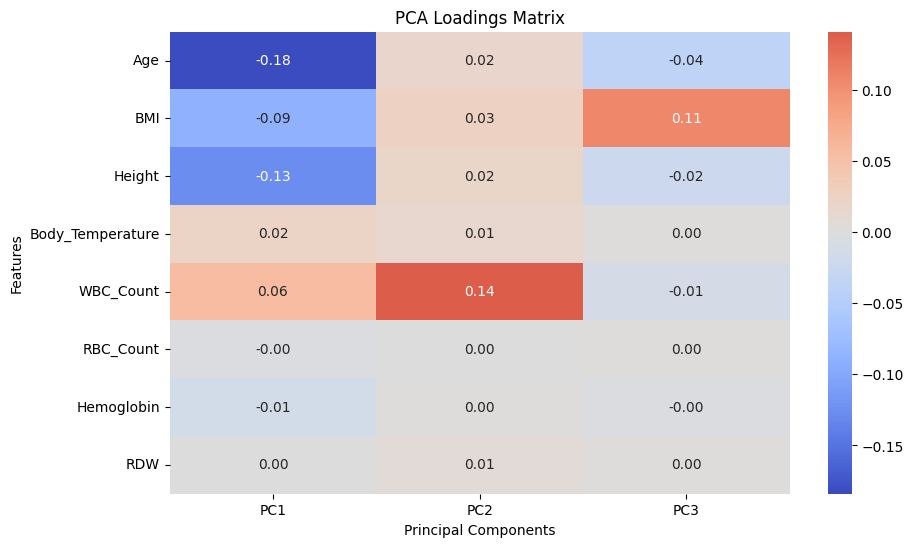

Data stored at: /Users/joseovalle/Desktop/mlops_jovalle/mlops_tec/mlops_tarea1/data/processed/uci_df.csv
Accuracy of the model: 0.949

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        64
           1       0.93      0.99      0.96        93

    accuracy                           0.95       157
   macro avg       0.96      0.94      0.95       157
weighted avg       0.95      0.95      0.95       157



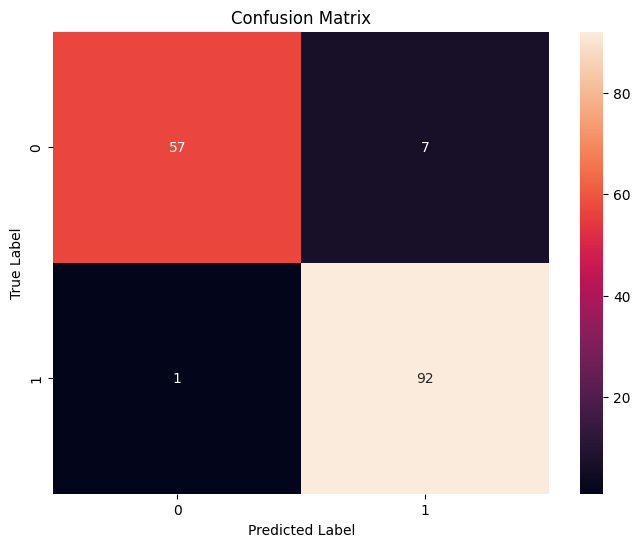

Model stored at: /Users/joseovalle/Desktop/mlops_jovalle/mlops_tec/mlops_tarea1/models/appendictis_model.pkl


In [230]:
# Pipeline

model = AppendicitisModel()

model.import_rawdata()
model.save_rawdata()

model.get_continuous_features()
model.get_categorical_features()
model.get_integer_features()
model.get_binary_features()

model.impute_continuous_features()
model.impute_integer_features()
model.impute_categorical_features()
model.impute_binary_features()
model.impute_target()

# model.run_eda()
model.normalize()
model.encode()
model.run_pca()
model.integrate_data()

model.save_preproccesed_data()

model.train_test_split()
model.train_random_forest()
model.export_model()
